20240306

SarahFong

Take output from DiffBind deseq2 formatting

          $HOME/EMF/US/bin/ATAC/1_prep_deseq2_ATAC.ipynb 
          
Prepare data: 
1. Load data per cl
2. Apply filters for min conc, quantile inclusion, jointaccessibility based on min conc, class labeling
3. Split into training, validation and test set - hold out chr12 for validation, chr8 for testing
4. Optional-Downsample training data
6. Shuffle and Add fold num to training set

In [2]:
from Bio.SeqIO.FastaIO import SimpleFastaParser
from Bio.Seq import reverse_complement, Seq
import config_readwrite as crw
import matplotlib.pyplot as plt
import numpy as np
import os, sys
import pandas as pd
import pybedtools as pbt

from scipy import stats

import seaborn as sns
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

import plot_params as pp
pp.fonts()

('sans-serif', 'Arial', 18)

In [3]:
config_name =os.path.join(os.getcwd(), "config.multi.ini")
config, cfn = crw.read(config_name)

# functions

In [4]:
def setPrefixRules(prefix):
    """ rules for processing datasets"""
    if "class.all" in prefix:
        QUANTILE_FILTER=False  # don't remove top quantile
        MIN_CONC_FILTER=True  # do require peak to meet min conc threshold in one of conditions
        JOINT_ACCESSIBLE=True  # do keep joint accessible elements
        CLASS_LABEL = True  # label classes w/deseq2 for classification tasks

    elif "class.nojoint" in prefix:
        QUANTILE_FILTER=False
        MIN_CONC_FILTER=True
        JOINT_ACCESSIBLE=False  # remove joint accessible elements
        CLASS_LABEL = True

    elif "reg.all" in PREFIX:
        QUANTILE_FILTER=False
        MIN_CONC_FILTER=True
        JOINT_ACCESSIBLE=True
        CLASS_LABEL = False  # use min_conc values for regression task

    elif "reg.nojoint" in prefix:
        QUANTILE_FILTER=False
        MIN_CONC_FILTER=True
        JOINT_ACCESSIBLE=False  # remove joint accessible elements
        CLASS_LABEL = False  # use min_conc values for regression task
    else:
        print('need to add rules for', prefix)
        
    return QUANTILE_FILTER, MIN_CONC_FILTER, JOINT_ACCESSIBLE, CLASS_LABEL


## make chromosome list

In [5]:
def chrList():
    """return  list of chromosomes"""

    chrs = []

    for n in np.arange(1, 23):
        chrs.append(f"chr{n}")

    # add sex chromosomes
    chrs.append("chrX")
    chrs.append("chrY")

    return chrs

## write fa

In [6]:
def writeFa(heldout_df, heldout_fa):
    with open(heldout_fa, "w") as writer:
        for row in heldout_df.iterrows():
            seqid, seq = row[1][:2]
            writer.write(f">{seqid}\n{seq}\n")

## train test split on chromosome

In [7]:
def splitTrainTestVal(df, val_chr_list=None, test_chr_list=None):
    """randomly sample and hold out 2 chromosomes for testing, validation"""

    cols = ['coor.type', "seq"]

    # randomly sample test chromosomes (n=2)
    if test_chr_list is None:
        print('randomly sampling chromosomes for test')

        # randomly sample
        test_chr_list = list(np.random.choice(chrs, 2))

    # randomly sample validation chromosome (n=1)
    if val_chr_list is None:
        print('randomly sampling chromosomes for val')

        # remove test chromosomes
        for chr_ in test_chr_list:
            chrs.remove(chr_)

        # randomly sample
        val_chr_list = list(np.random.choice(chrs, 1))

    # separate held out chromosomes from  training chromosomes
    test = df.loc[df["#chr"].isin(test_chr_list)].copy()
    val = df.loc[df["#chr"].isin(val_chr_list)].copy()
    train = df.loc[(~df["#chr"].isin(test_chr_list)) &
                   (~df["#chr"].isin(val_chr_list))].copy()

    return train, val, test

## filters

In [8]:
def minConcFilter(table, min_conc, filter_bool=True):
    """Filter control and US atac for a min concentration threshold
        Require threshold in control OR ultrasound, but both not necessary (differentially accessible)
    """
    if filter_bool is True:
        print("before minconc filter:", table.shape)
        table = table.loc[(table["ctrl"] > min_conc) |
                          (table["US"] > min_conc)].copy()
        print("after:", table.shape)
    else:
        print("no min conc filtering")

    return table


def quantileFilter(table, filter_bool=False, quantile=0.99):
    """upper quantile filter for read count values. Only upper because lower threshold is zero."""

    if filter_bool is True:
        print("before quantile filter:", table.shape)

        # quantiles
        ctrl_thresh, us_thresh = table[["ctrl", "US"]].quantile(quantile)

        # filter table
        table = table.loc[(table["ctrl"] < ctrl_thresh) &
                          (table["US"] < us_thresh)]

        print("after:", table.shape)
    else:
        print("no quantile filter")

    return table


def jointAccessibleFilter(table, filter_bool=True):
    """remove joint accessible regions, scramble new dataframe"""

    if filter_bool is False:
        print("before joint_accessible filter:", table.shape)

        # filter table
        ctrl_only = table.loc[(table["ctrl"] > 0) &
                              (table["US"] == 0)].copy()

        US_only = table.loc[(table["ctrl"] == 0) &
                            (table["US"] > 0)].copy()

        # combine us and ctrl, shuffle dataframe
        table = dfShuffle(pd.concat([ctrl_only, US_only]))

        print("after:", table.shape)
    else:
        print('keeping jointly accessible elements')

    return table

# label based on min_conc value


def minConcClassLabel(table):
    """ RETIRED-binarize read count column based on min_conc"""
    cols_to_label = ['ctrl', 'US']
    for col in cols_to_label:
        table[col] = table[col].apply(lambda x: 0 if x < MIN_CONC else 1)

    return table

# label deseq2 DiffAcc peaks


def diffAccLabel(table, diff_bed, filter_bool=False):
    """ Annotate elements that overlap desseq2 differentially accessible peak calls
        Intersect peaks w/ DESEQ2 differentially accessible peaks.
        Label any peak with 1+ bp overlapping DESEQ2 element. 
        Return dataframe of overlapping elements. 
    """
    if filter_bool is True:
        print("labeling peaks overlapping deseq2 diffAcc by >=1 bp")
        table_bed = pbt.BedTool.from_dataframe(table[table.columns[:4]])
        deseq_bed = pbt.BedTool(diff_bed)

        # intersect table x deseq2, write all present, absent overlaps.
        table_deseq = table_bed.intersect(deseq_bed, wao=True)

        # load intersection results
        table_deseq = pd.read_csv(table_deseq.fn, sep='\t', header=None)
        table_deseq.columns = ['#chr', "start_trim", "end_trim", "id",
                               "#chr_deseq", "start_deseq", "end_deseq",
                               "deseq_id", "diffAcc"
                               ]

        # if peak overlaps DESEQ2 element by 1+ bp
        # annotate diffAcc overlap as 1 or 0
        table_deseq["diffAcc"] = table_deseq["diffAcc"].apply(
            lambda x: 1 if x >= 1 else 0)

        # merge annotations with original table
        table = pd.merge(
            table, table_deseq[["id", "diffAcc"]]).drop_duplicates()
    else:
        print('not labeling deseq2-overlapping peaks. What is your label again?')

    # return dataframe w/ names and deseq2 overlaps
    return table


# scramble df
def dfShuffle(df):
    """scramble dataframe"""
    return df.sample(frac=1).reset_index(drop=True)


# sequences where US increases activity only
def directionFilter(table, filter_bool=False):
    """filter for positive directional changes in activity"""
    if filter_bool is True:
        print('include sequences that increase activity w US')
        # where US_DIF = ctrl - US, and US_dif <0 means US has more activity than control
        table = table.loc[table["US_DIF"] < 0]

    else:
        print('include ALL sequences that increase|decrease|no activity change w US')
    return table


# downsample
def downsampleNegClass(train, filter_bool=False):
    """downsample training set only"""

    if filter_bool is True:
        # get positive and negatives
        pos, neg = train.loc[train["diffAcc"] > 0].copy(
        ), train.loc[train["diffAcc"] == 0].copy()

        # count the positive examples
        # ctrl - US <0 means US has more activity than control
        n_pos = pos.shape[0]

        print("downsampling training data!\n percent with a positive label:",
              round(n_pos/train.shape[0], 2), n_pos,
              "\n"
              )

        # randomly sample negative examples
        neg_downsample = neg.sample(n=n_pos)
        print("\n\n AFTER DOWNSAMPLING", len(neg_downsample))

        # return concatenated dataframe of downsampled negative class.
        return pd.concat([pos, neg_downsample])

In [9]:
def reverseSeq(df):
    """make reverse complement and annotate df 
    """
    df_r = df.copy()  # copy df

    df_r["reverse"] = 1  # annotated reverse complement

    # make reverse complement
    df_r['seq'] = df_r["seq"].apply(lambda x: str(reverse_complement(Seq(x))))

    # annotate reverse in coor.type
    df_r['coor.type'] = df_r["coor.type"] + "|r"

    # annoate forward in coor.type
    df["reverse"] = 0
    df['coor.type'] = df["coor.type"] + "|f"

    # concat forward and reverse
    df_concat = pd.concat([df, df_r])

    return df_concat

# Main

## params

In [10]:
WINDOW = True
if WINDOW is True:
    PREFIX = "class.all.1task_windows"
else:
    PREFIX = "class.all.1task"
PATH = "/wynton/group/ahituv/data/US-MPRA/ATAC-seq/Diffbind_results"
TEST_CHR = ["chr1"]
VAL_CHR = ["chr12"]


# peak information
PEAK_SIZE = 270
MIN_CONC = 2  # NOTE -  $HOME/EMF/US/bin/ATAC/1_prep_deseq2_ATAC.ipynb may have pre-filtered the min_conc value
DIRECTION_FILTER = False  # keep only positive changes? Negative changes?
DOWNSAMPLE = True

# genome information
HG38 = "/wynton/group/ahituv/data/dna/hg38/hg38.chrom.sizes"
FA_HG38 = "/wynton/group/ahituv/data/dna/hg38/hg38.fa"

## load data + filter per cell line 

In [11]:
# collect cell-specific annotations
train_dict, val_dict, test_dict = {}, {}, {}

# set columns
if "class" in PREFIX:
    # classification task
    cols = ["coor.type", "diffAcc"]
else:
    # regression task
    cols = ["coor.type", "US", "ctrl",  # "US_DIF"
            ]

fa_cols = ['coor.type', "seq"]


for CL in ["hob", "hepg2", "k562", "bj"]:  # CL = 'hob'
    print(CL)

    # Instantiate cell- and task-specific path.
    DATA_PATH = f"/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/{CL}/{PREFIX}"

    # make cl- and task-specific datapath
    if os.path.exists(DATA_PATH) is False:
        if os.path.dirname(DATA_PATH) is False:
            os.mkdir(os.path.dirname(DATA_PATH))
        os.mkdir(DATA_PATH)

    # cell-specific base files

    # DESEQ2 files
    DIFF = f'./{CL}_deseq2.csv'
    NODIFF = f'./{CL}_deseq2-nodiff.csv'
    DIFF_BED = "./" + DIFF.strip(".csv") + ".bed"

    # FULL peakset called from deseq2, trimmed to 270bp.
    if WINDOW is True:
        FULL = f"{CL}_deseq2-nondiff.window.min_conc.{MIN_CONC}.full.csv"
    else:
        FULL = f"{CL}_deseq2-nondiff.trimmed.min_conc.{MIN_CONC}.full.csv"

    os.chdir(DATA_PATH)
    ### Write CONFIG FILE ###
    # base config
    section = f"{CL}-ATAC-DESEQ2"
    crw.check(config, section)

    config[section]["path"] = PATH

    config[section]["nondiff_bind_results"] = "%(path)s/" + NODIFF
    config[section]["diff_bind_results"] = "%(path)s/" + DIFF
    config[section]["diff_bind_results_bed"] = "%(path)s/" + DIFF_BED

    # deepstarr files

    # file inputs for training, testing
    TRAIN_FA = f"{PREFIX}.Sequences_Train.fa"
    VAL_FA = f"{PREFIX}.Sequences_Val.fa"
    TEST_FA = f"{PREFIX}.Sequences_Test.fa"

    # y
    TRAIN_TARGET = f"{PREFIX}.Sequences_activity_Train.txt"
    VAL_TARGET = f"{PREFIX}.Sequences_activity_Val.txt"
    TEST_TARGET = f"{PREFIX}.Sequences_activity_Test.txt"

    # rules

    # deepstarr config
    section = f"{CL}.atac.deseq2.deepstarr"
    crw.check(config, section)

    config[section]["data_path"] = DATA_PATH
    config[section]["held_out_chr"] = ",".join(TEST_CHR)
    config[section]["val_chr"] = ",".join(VAL_CHR)

    # deepstarr+prefix config

    # rules for data
    QUANTILE_FILTER, MIN_CONC_FILTER, JOINT_ACCESSIBLE, CLASS_LABEL = setPrefixRules(
        PREFIX)

    # deepstarr prefix config
    section = f"{CL}.atac.deseq2.deepstarr.{PREFIX}"
    crw.check(config, section)

    config[section]["train_fa"] = TRAIN_FA
    config[section]["val_fa"] = VAL_FA
    config[section]["test_fa"] = TEST_FA

    config[section]["train_target"] = TRAIN_TARGET
    config[section]["tval_target"] = VAL_TARGET
    config[section]["test_target"] = TEST_TARGET

    config[section]["filter_MIN_CONC"] = str(MIN_CONC_FILTER)
    if MIN_CONC_FILTER is True:
        config[section]["MIN_CONC"] = str(MIN_CONC)

    config[section]["filter_quantile"] = str(QUANTILE_FILTER)
    config[section]["filter_jointaccessible"] = str(JOINT_ACCESSIBLE)
    config[section]["classlabel"] = str(CLASS_LABEL)

    crw.write(config, cfn)

    ### load data ###
    os.chdir(PATH)
    table = pd.read_csv(FULL, sep='\t').drop_duplicates()

    table["coor.type"] = table["type"] + "|" + table["seq.id"]

    if "Conc_Ultrasound_dif" not in list(table):
        table["Conc_Ultrasound_dif"] = table["Conc_Control"] - \
            table["Conc_Ultrasound"]

    table.rename(columns={"Conc_Ultrasound": "US",
                          "Conc_Control": "ctrl",
                          "Conc_Ultrasound_dif": "US_DIF"}, inplace=True)

    # remove alternative chromosome alignments
    table = table.loc[~table['#chr'].str.contains('v')]

    print("original dataset shape", table.shape)

    ### FILTER ###

    # mean read depth filter
    # remove noisy peaks with low read counts.
    # table = minConcFilter(table, MIN_CONC, MIN_CONC_FILTER) # not needed, done in the previous step

    # quantile filter - remove any peaks above the quantile.
    # important for regression-task
    table = quantileFilter(table, QUANTILE_FILTER, quantile=0.99)

    # joint accessible filter
    table = jointAccessibleFilter(table, JOINT_ACCESSIBLE)

    # apply class label—1 if diffAcc, 0 if not.

    table = diffAccLabel(table, DIFF_BED, CLASS_LABEL)
    # print(table.groupby(['ctrl', "US", "US_DIF", "diffAcc"])['#chr'].count())

    # filter for us-increasing sequences?
    table = directionFilter(table, DIRECTION_FILTER)

    # annotate which cl this is
    table["cl"] = CL

    ### TRAIN TEST SPLIT ###
    # train on atac peaks
    os.chdir(DATA_PATH)

    table = dfShuffle(table)  # shuffle the table before splitting

    train, val, test = splitTrainTestVal(
        table, val_chr_list=VAL_CHR, test_chr_list=TEST_CHR)

    print("positives in train", table.groupby("diffAcc")[
          "seq"].count())
    print("positives in val, test", val.groupby("diffAcc")[
          "seq"].count(), test.groupby("diffAcc")["seq"].count())

    # downsample training data
    train = downsampleNegClass(train, DOWNSAMPLE)
    print("train after downsampling", train.groupby(['diffAcc'])["seq"].count())

    # add reverse complement to sequences in table
    print("reversing the sequences")
    
    train = reverseSeq(train)
    val = reverseSeq(val)
    test = reverseSeq(test)

    # shuffle the training set for good measure
    train = dfShuffle(train)
    
    writeFa(train[fa_cols], TRAIN_FA)
    writeFa(val[fa_cols], VAL_FA)
    writeFa(test[fa_cols], TEST_FA)

    
    train[cols].to_csv(TRAIN_TARGET, sep='\t', index=False)
    val[cols].to_csv(VAL_TARGET, sep='\t', index=False)
    test[cols].to_csv(TEST_TARGET, sep='\t', index=False)
    print(train.shape, val.shape, test.shape, "\n\n")

    train_dict[CL], val_dict[CL], test_dict[CL] = train, val, test
    

hob
original dataset shape (492730, 12)
no quantile filter
keeping jointly accessible elements
labeling peaks overlapping deseq2 diffAcc by >=1 bp
include ALL sequences that increase|decrease|no activity change w US
positives in train diffAcc
0    476661
1     16069
Name: seq, dtype: int64
positives in val, test diffAcc
0    22792
1      658
Name: seq, dtype: int64 diffAcc
0    43190
1     1386
Name: seq, dtype: int64
downsampling training data!
 percent with a positive label: 0.03 14025 



 AFTER DOWNSAMPLING 14025
train after downsampling diffAcc
0    14025
1    14025
Name: seq, dtype: int64
reversing the sequences
(56100, 15) (46900, 15) (89152, 15) 


hepg2
original dataset shape (579299, 12)
no quantile filter
keeping jointly accessible elements
labeling peaks overlapping deseq2 diffAcc by >=1 bp
include ALL sequences that increase|decrease|no activity change w US
positives in train diffAcc
0    570649
1      8650
Name: seq, dtype: int64
positives in val, test diffAcc
0    24997


# combine training, test data across cell types. 

## config - write

In [12]:
if WINDOW is True:
    DATA_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/all/class.all.balanced_window"
else:
    DATA_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/all/class.all.balanced"
if os.path.exists(DATA_PATH) is False:
    os.mkdir(DATA_PATH)
os.chdir(DATA_PATH)
CL = "allcl"
PREFIX="general"


# file inputs for training, testing
TRAIN_FA = f"{PREFIX}.Sequences_Train.fa"
VAL_FA = f"{PREFIX}.Sequences_Val.fa"
TEST_FA = f"{PREFIX}.Sequences_Test.fa"

## y
TRAIN_TARGET = f"{PREFIX}.Sequences_activity_Train.txt"
VAL_TARGET = f"{PREFIX}.Sequences_activity_Val.txt"
TEST_TARGET = f"{PREFIX}.Sequences_activity_Test.txt"

## rules

## deepstarr config 
section = f"{CL}.atac.deseq2.deepstarr"
crw.check(config, section)

config[section]["data_path"] = DATA_PATH
config[section]["held_out_chr"] = ",".join(TEST_CHR)
config[section]["val_chr"] = ",".join(VAL_CHR)

# deepstarr prefix config
section = f"{CL}.atac.deseq2.deepstarr.{PREFIX}"
crw.check(config, section)

config[section]["train_fa"] = TRAIN_FA
config[section]["val_fa"] = VAL_FA
config[section]["test_fa"] = TEST_FA

config[section]["train_target"] = TRAIN_TARGET
config[section]["tval_target"] = VAL_TARGET
config[section]["test_target"] = TEST_TARGET

config[section]["filter_MIN_CONC"] = str(MIN_CONC_FILTER)
if MIN_CONC_FILTER is True:
    config[section]["MIN_CONC"] = str(MIN_CONC)

config[section]["filter_quantile"] = str(QUANTILE_FILTER)
config[section]["filter_jointaccessible"] = str(JOINT_ACCESSIBLE)
config[section]["classlabel"] = str(CLASS_LABEL)

crw.write(config, cfn)

## concat dictionaries

In [13]:
train_full = pd.concat(train_dict.values())
val_full = pd.concat(val_dict.values())
test_full = pd.concat(test_dict.values())

In [14]:
train_full.head()

,#chr,start,end,id,type,winnum,seq.id,US,ctrl,US_DIF,seq,coor.type,diffAcc,cl,reverse
0,chr6,167797154,167797424,hob.2370_4,hob.2370,4,chr6:167797154-167797424,2.816497,1.229946,-1.586551,CACGCGCTGGCCCTCCCCGTCCACAGCAGCAGCGGCATCCTCCCCA...,hob.2370|chr6:167797154-167797424|f,1,hob,0
1,chr10,1110158,1110428,hob.41899_3,hob.41899,3,chr10:1110158-1110428,4.884773,4.587460,-0.297313,CGGAGACAAAGGCAAGTGTTACTAAGAAGACACCTCAGATGAAACA...,hob.41899|chr10:1110158-1110428|r,0,hob,1
2,chr16,46831297,46831567,hob.245_1,hob.245,1,chr16:46831297-46831567,8.756711,8.465767,-0.290945,CTGGGCGCCAAGGGGGCGGGGCGGAGCGTCGGCCGGCGGCTCCTGG...,hob.245|chr16:46831297-46831567|f,1,hob,0
3,chr8,37779901,37780171,hob.4772_3,hob.4772,3,chr8:37779901-37780171,6.362822,6.013889,-0.348932,agctggtatcgaacccctgaggctcTGCAAGTCACACTATCACTTG...,hob.4772|chr8:37779901-37780171|r,1,hob,1
4,chr3,197394688,197394958,hob.2589_6,hob.2589,6,chr3:197394688-197394958,7.422553,7.129143,-0.293410,CTGGTTCTCAAGGTTTCGGTGATGAGTCACCTCGTTCCCCCTCACC...,hob.2589|chr3:197394688-197394958|f,1,hob,0


## write full tables

In [15]:
# write fasta
writeFa(test_full[fa_cols], TEST_FA)
writeFa(train_full[fa_cols], TRAIN_FA)
writeFa(val_full[fa_cols], VAL_FA)

# write fasta
test_full[cols].to_csv(TEST_TARGET, sep='\t', index=False)
train_full[cols].to_csv(TRAIN_TARGET, sep='\t', index=False)
val_full[cols].to_csv(VAL_TARGET, sep='\t', index=False)

# report nrows
train_full.shape[0], val_full.shape[0], test_full.shape[0]

(113292, 232750, 487830)

## write HepG2+K562 positive control sets

In [22]:
if WINDOW is True:
    DATA_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/pos/class.all.balanced_window"
else:
    DATA_PATH = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/pos/class.pos.balanced"
if os.path.exists(DATA_PATH) is False:
    os.mkdir(DATA_PATH)
os.chdir(DATA_PATH)
CL = "pos"
PREFIX="class.all"


# file inputs for training, testing
TRAIN_FA = f"{PREFIX}.Sequences_Train.fa"
VAL_FA = f"{PREFIX}.Sequences_Val.fa"
TEST_FA = f"{PREFIX}.Sequences_Test.fa"

## y
TRAIN_TARGET = f"{PREFIX}.Sequences_activity_Train.txt"
VAL_TARGET = f"{PREFIX}.Sequences_activity_Val.txt"
TEST_TARGET = f"{PREFIX}.Sequences_activity_Test.txt"

## rules

## deepstarr config 
section = f"{CL}.atac.deseq2.deepstarr"
crw.check(config, section)

config[section]["data_path"] = DATA_PATH
config[section]["held_out_chr"] = ",".join(TEST_CHR)
config[section]["val_chr"] = ",".join(VAL_CHR)

# deepstarr prefix config
section = f"{CL}.atac.deseq2.deepstarr.{PREFIX}"
crw.check(config, section)

config[section]["train_fa"] = TRAIN_FA
config[section]["val_fa"] = VAL_FA
config[section]["test_fa"] = TEST_FA

config[section]["train_target"] = TRAIN_TARGET
config[section]["tval_target"] = VAL_TARGET
config[section]["test_target"] = TEST_TARGET

config[section]["filter_MIN_CONC"] = str(MIN_CONC_FILTER)
if MIN_CONC_FILTER is True:
    config[section]["MIN_CONC"] = str(MIN_CONC)

config[section]["filter_quantile"] = str(QUANTILE_FILTER)
config[section]["filter_jointaccessible"] = str(JOINT_ACCESSIBLE)
config[section]["classlabel"] = str(CLASS_LABEL)

crw.write(config, cfn)

## keep only HepG2 and k562 data

In [23]:
def relabelDiffAcc(df):
    # change diff_acc column to reflect cell line (0-hepg2, 1-k562)
    # this way, instead of predicting US-response, I predict whether a sequence is HepG2 or K562-specific
    
    df.loc[df["cl"]=="hepg2", "diffAcc"]=0
    df.loc[df["cl"]=="k562", "diffAcc"]=1
    print(df.groupby("cl")["seq"].count())
    
    return df

In [24]:
pos_cl=["hepg2", "k562"]
train_pos = train_full.loc[train_full["cl"].isin(pos_cl)].copy()
val_pos = val_full.loc[val_full["cl"].isin(pos_cl)].copy()
test_pos = test_full.loc[test_full["cl"].isin(pos_cl)].copy()

# relabel diffacc column with cell-type-specific peaks
train_pos, val_pos, test_pos = relabelDiffAcc(train_pos), relabelDiffAcc(val_pos), relabelDiffAcc(test_pos)

cl
hepg2    30440
k562     17876
Name: seq, dtype: int64
cl
hepg2    50750
k562     66710
Name: seq, dtype: int64
cl
hepg2    106400
k562     160762
Name: seq, dtype: int64


In [25]:
# write fasta

writeFa(train_pos[fa_cols], TRAIN_FA)
writeFa(val_pos[fa_cols], VAL_FA)
writeFa(test_pos[fa_cols], TEST_FA)

# write fasta

train_pos[cols].to_csv(TRAIN_TARGET, sep='\t', index=False)
val_pos[cols].to_csv(VAL_TARGET, sep='\t', index=False)
test_pos[cols].to_csv(TEST_TARGET, sep='\t', index=False)

# report nrows
train_pos.shape[0], val_pos.shape[0], test_pos.shape[0]

(48316, 117460, 267162)

In [26]:
DATA_PATH

'/wynton/home/ahituv/fongsl/EMF/US/ml_emf/data/deepstarr/deseq2/pos/class.all.balanced_window'

## table pivot 
- 1 = diff accessible element. 
- 0 = not dif accessible OR NOT accessible. This might be a problem, as some sequences may be predicted zero because they are not differentially accessible or because they are not present in a cell type at all. 


### Experimental question
- should US-sensitivity be predicted as a cell-type-specific task? or just in general?

    - One hypothesis for in general: DA elements have sequence similarity between cell lines, but are accessible at different loci depending on cell-type. This suggests similar trans-regulatory responses, but cis-regulatory effects that are cell-type-specific. In this case, predicting DA based on sequence, regardless of cell type, is an appropriate classification task. 
    
    - One hypothesis for in cl-specific: DA elements have distinct sequences across cell lines and are accessible at different loci depending on cell-type. This would suggest different trans-regulatory responses per cell line, producing different cis-regulatory effects that are cell-type-specific. In this case, predicting DA based on both sequence AND cell type is appropriate. 

In [55]:

CL = "allcl-stratified"
PREFIX="cl-specific"


# file inputs for training, testing
TRAIN_FA = f"{PREFIX}.Sequences_Train.fa"
VAL_FA = f"{PREFIX}.Sequences_Val.fa"
TEST_FA = f"{PREFIX}.Sequences_Test.fa"

## y
TRAIN_TARGET = f"{PREFIX}.Sequences_activity_Train.txt"
VAL_TARGET = f"{PREFIX}.Sequences_activity_Val.txt"
TEST_TARGET = f"{PREFIX}.Sequences_activity_Test.txt"

## rules

## deepstarr config 
section = f"{CL}.atac.deseq2.deepstarr"
crw.check(config, section)

config[section]["data_path"] = DATA_PATH
config[section]["held_out_chr"] = ",".join(TEST_CHR)
config[section]["val_chr"] = ",".join(VAL_CHR)

# deepstarr prefix config
section = f"{CL}.atac.deseq2.deepstarr.{PREFIX}"
crw.check(config, section)

config[section]["train_fa"] = TRAIN_FA
config[section]["val_fa"] = VAL_FA
config[section]["test_fa"] = TEST_FA

config[section]["train_target"] = TRAIN_TARGET
config[section]["tval_target"] = VAL_TARGET
config[section]["test_target"] = TEST_TARGET

config[section]["filter_MIN_CONC"] = str(MIN_CONC_FILTER)
if MIN_CONC_FILTER is True:
    config[section]["MIN_CONC"] = str(MIN_CONC)

config[section]["filter_quantile"] = str(QUANTILE_FILTER)
config[section]["filter_jointaccessible"] = str(JOINT_ACCESSIBLE)
config[section]["classlabel"] = str(CLASS_LABEL)

crw.write(config, cfn)

In [56]:
# pivot tables. 
train_full_table=pd.pivot(train_full, columns = "cl", index="coor.type", values="diffAcc").fillna(0).reset_index()
val_full_table=pd.pivot(val_full, columns = "cl", index="coor.type", values="diffAcc").fillna(0).reset_index()
test_full_table=pd.pivot(test_full, columns = "cl", index="coor.type", values="diffAcc").fillna(0).reset_index()

# add sequences bak
train_full_table=pd.merge(train_full[["coor.type", "seq"]], train_full_table)
val_full_table=pd.merge(val_full[["coor.type", "seq"]], val_full_table)
test_full_table=pd.merge(test_full[["coor.type", "seq"]], test_full_table)

### write pivot tables

In [19]:
# write fasta
writeFa(test_full_table[fa_cols], TEST_FA)
writeFa(train_full_table[fa_cols], TRAIN_FA)
writeFa(val_full_table[fa_cols], VAL_FA)

# write target
cols = list(test_full_table.columns)
cols.remove("seq")

test_full_table[cols].to_csv(TEST_TARGET, sep='\t', index=False)
train_full_table[cols].to_csv(TRAIN_TARGET, sep='\t', index=False)
val_full_table[cols].to_csv(VAL_TARGET, sep='\t', index=False)

# report nrows
train_full_table.shape[0], val_full_table.shape[0], test_full_table.shape[0]

(113292, 232750, 487830)

### side quest - DiffAcc elements are cell type-specific 

In [20]:
# there are no training examples where a regulatory element has US sensitive activity >1 cell type. See col 0
train_full_table.sum(axis=1).reset_index().sort_values(by=0, ascending=False)  

TypeError: can only concatenate str (not "float") to str

# compare before and after windowing and reverse complement

## balanced training 

In [28]:
train_full[["type", "diffAcc", "cl"]].drop_duplicates().groupby(["cl", "diffAcc"])["type"].count()

cl     diffAcc
bj     0           2194
       1            317
hepg2  0           7254
       1           1089
hob    0          12666
       1           2005
k562   0           4366
       1            640
Name: type, dtype: int64

In [29]:
train_full[["id", "coor.type", "diffAcc", "cl"]].drop_duplicates().groupby(["cl", "diffAcc"])["id"].count()

cl     diffAcc
bj     0           4438
       1           4438
hepg2  0          15220
       1          15220
hob    0          28050
       1          28050
k562   0           8938
       1           8938
Name: id, dtype: int64

##  validation

In [30]:
val_full[["type", "diffAcc", "cl"]].drop_duplicates().groupby(["cl", "diffAcc"])["type"].count()

cl     diffAcc
bj     0          4870
       1            15
hepg2  0          3571
       1            54
hob    0          3256
       1            94
k562   0          4721
       1            44
Name: type, dtype: int64

In [31]:
val_full[["id", "coor.type", "diffAcc", "cl"]].drop_duplicates().groupby(["cl", "diffAcc"])["id"].count()

cl     diffAcc
bj     0          68180
       1            210
hepg2  0          49994
       1            756
hob    0          45584
       1           1316
k562   0          66094
       1            616
Name: id, dtype: int64

## test

In [58]:
test_full[["type", "diffAcc", "cl"]].drop_duplicates().groupby(["cl", "diffAcc"])["type"].count()

cl     diffAcc
bj     0           9356
       1             38
hepg2  0           7506
       1             95
hob    0           6170
       1            198
k562   0          11394
       1             89
Name: type, dtype: int64

In [34]:
test_full[["id", "coor.type", "diffAcc", "cl"]].drop_duplicates().groupby(["cl", "diffAcc"])["id"].count()

cl     diffAcc
bj     0          130984
       1             532
hepg2  0          105076
       1            1324
hob    0           86380
       1            2772
k562   0          159516
       1            1246
Name: id, dtype: int64

## EDA

### per cell line - N training elements 

In [59]:
RE = "/wynton/home/ahituv/fongsl/EMF/US/ml_emf/results/eda"

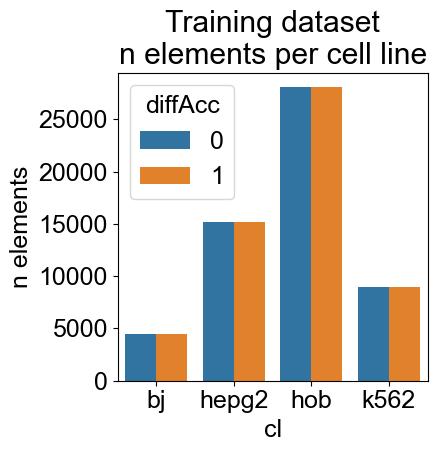

In [60]:
plot = train_full.groupby(["cl", "diffAcc"]).count().reset_index()

# plot
fig, ax=plt.subplots(figsize=(4,4))
sns.barplot(x="cl", y="#chr", data=plot, hue="diffAcc")
ax.set(title="Training dataset\nn elements per cell line", 
      ylabel="n elements")
out = os.path.join(RE, "training.balanced.windowed.per.cl.pdf")
plt.savefig(out, bbox_inches="tight")

### per cell line - N test elements 

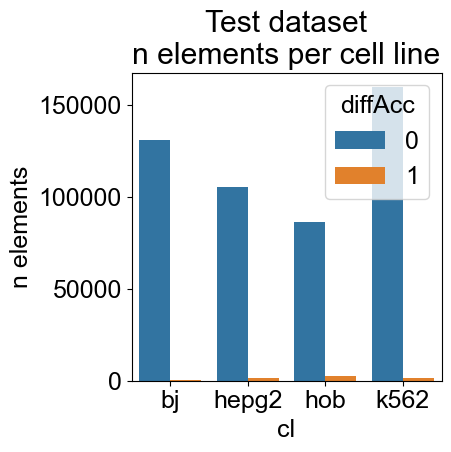

In [69]:
plot = test_full.groupby(["cl", "diffAcc"]).count().reset_index()

# plot
fig, ax=plt.subplots(figsize=(4,4))
sns.barplot(x="cl", y="#chr", data=plot, hue="diffAcc")
ax.set(title="Test dataset\nn elements per cell line", 
      ylabel="n elements")
out = os.path.join(RE, f"test.{TEST_CHR[0]}.windowed.per.cl.pdf")
plt.savefig(out, bbox_inches="tight")

### per cell line, chromosome, N training elements

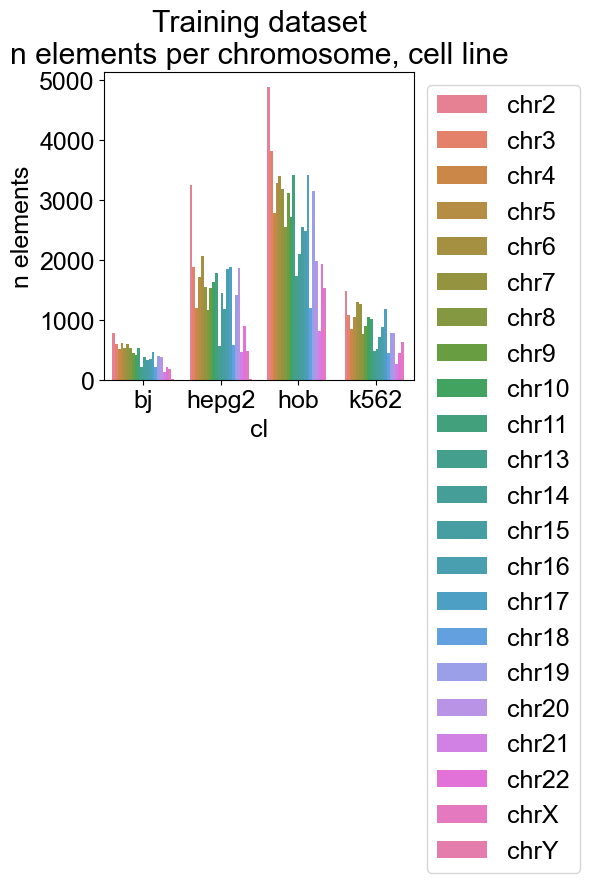

In [70]:
plot = train_full.groupby(["#chr", "cl"]).count().reset_index()

chr_list = chrList()
chr_list.remove(TEST_CHR[0]) 
chr_list.remove(VAL_CHR[0])

# plot
fig, ax=plt.subplots(figsize=(4,4))
sns.barplot(x="cl", y="start", data=plot, hue="#chr", hue_order=chr_list)
ax.set(title="Training dataset\nn elements per chromosome, cell line", 
      ylabel="n elements")
ax.legend(bbox_to_anchor=(1,1))

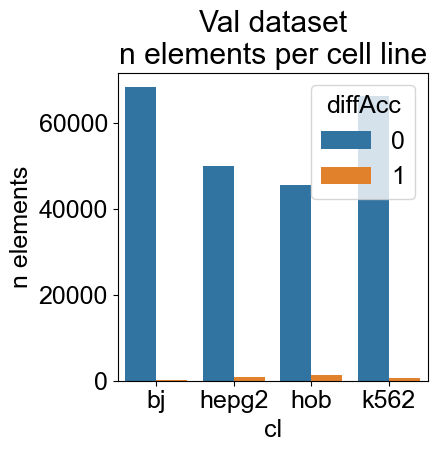

In [71]:
plot = val_full.groupby(["cl", "diffAcc"]).count().reset_index()

# plot
fig, ax=plt.subplots(figsize=(4,4))
sns.barplot(x="cl", y="#chr", data=plot, hue="diffAcc")
ax.set(title="Val dataset\nn elements per cell line", 
      ylabel="n elements")
out = os.path.join(RE, f"val.{VAL_CHR[0]}.windowed.per.cl.pdf")
plt.savefig(out, bbox_inches="tight")

### peak at training dataframe